In [1]:
import sys

path_append = "../" # Go up one directory from where you are.
sys.path.append(path_append) 

import torch
from tools.setting.ml_params import MLParameters
from tools.setting.data_config import DataConfig
from nn.utils.init import set_random_seed
set_random_seed(0)

In [2]:
from torchvision import datasets, transforms

n_img_sz = 28  
attribute_indices = torch.tensor([4, 9])

transform_mnist = transforms.Compose([
    transforms.Resize(n_img_sz),  
    transforms.ToTensor(),  
    transforms.Normalize((0.5,), (0.5,)),  
])

trainset = datasets.MNIST(root='../data/mnist', train=True, transform=transform_mnist, download=True)
testset = datasets.MNIST(root='../data/mnist', train=False, transform=transform_mnist, download=True)
label_size = len(trainset.classes)


In [3]:
#  Set training configuration from the AlgorithmConfig class, returning them as a Namespace object.
ml_params = MLParameters(core_model = 'resnet18', encoder_model = 'none')
ml_params.model.core_config.num_layers = 4

obs_shape = trainset[0][0].shape

print(f"Input shape: {obs_shape}")
print(f"Label shape: {label_size}")

print(f"Total number of samples in trainset: {len(trainset)}")

data_config = DataConfig(dataset_name = 'mnist', task_type='multi_class_classification', obs_shape=obs_shape, label_size= label_size,
                         show_image_indices=[1, 3, 5, 7, 2, 0, 13, 15, 31, 19])

Input shape: torch.Size([1, 28, 28])
Label shape: 10
Total number of samples in trainset: 60000


In [4]:
# Custom dataset class for CelebA dataset
class Mnist(torch.utils.data.Dataset):
    def __init__(self, dataset):
        self.dataset = dataset
        self.attribute_indices = attribute_indices
        
    def __getitem__(self, index):
        X, y = self.dataset[index]  # Get the image and label at the specified index

        # Ensure y is an integer and within the expected range
        y = torch.tensor(y, dtype=torch.long)
        y_one_hot = torch.nn.functional.one_hot(y, num_classes=label_size)
        return X, y_one_hot  # Return the image and the one-hot encoded label
    
    def __len__(self):
        return len(self.dataset) # Return the size of the dataset
        
trainset = Mnist(trainset)
testset = Mnist(testset)

In [5]:
from trainer_hub import TrainerHub

# Set the device to GPU if available, else CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 

# Initialize the TrainerHub class with the training configuration, data configuration, device, and use_print and use_wandb flags
trainer_hub = TrainerHub(ml_params, data_config, device, use_print=True, use_wandb=False)

c:\Users\user\.conda\envs\torch\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\user\.conda\envs\torch\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



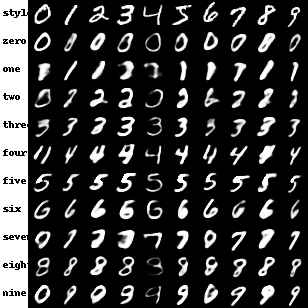

[0/100][800/937][Time 2.26]
Unified LR across all optimizers: 0.00019275692773582703
--------------------Training Metrics--------------------
Cooperative Network(core):  Three Resnet18
Inf: 0.0133	Gen: 0.0995	Rec: 0.0991	E: 0.0137	R: 0.0128	P: 0.1854
--------------------Test Metrics------------------------
accuracy: 0.9414
precision: 0.9416
recall: 0.9413
f1_score: 0.9397



In [6]:
trainer_hub.train(trainset, testset)